#  👉 [<span style="color:green"> ОТЧЕТ </span>](#report) 

<h1>  Финальный проект - Промышленность </h1> 

**<big>ПЛАН РАБОТЫ</big>** <a id='project_plan'></a>

1. Загрузка и изучение данных (общая/статистическая информация, визуализация).
2. Подготовка данных:    
  * Предобработка данных (обработка NaN/аномалий, изменение типов данных/названий столбцов; назначение *key* индексом датасетов).
  * Формирование единой таблицы данных: выбор партий с корректным соотношением времени замера технологических процессов; добавление новых столбцов (~например, длительностью замеров, интеграции активной и реактивной мощностей и пр.~) и дальнейший анализ влияния новых данных на значение метрики;
  * Подготовка данных к обучению (выделение признаков и целевого признака, проверка на мультиколлинеарность; разбиение на выборки). 
3. Исследование разных моделей. Для обучение выберем регрессионные модели LinearRegression, *Ridge*, RandomForest, ~XGBoost~, CatBoost, LightGBM. Оценка их качества и выбор лучшей модели для проверки её на тестовой выборке.
4. Подготовка отчета о проделанной работе.

# Содержание

* [1. Загрузка и изучение данных](#data_exploration)
  * [1. Таблица данных об электродах](#arc)
  * [2. Таблица данных о подаче сыпучих материалов (объем)](#bulk_volume)
  * [3. Таблица данных о подаче сыпучих материалов (время)](#bulk_time)
  * [4. Таблица данных о продувке сплава газом](#gas)
  * [5. Таблица данных о проволочных материалах (объем)](#wire_volume)
  * [6. Таблица данных о проволочных материалах (время)](#wire_time)
  * [7. Таблица данных о результатах измерения температуры](#temp)
  * [Вывод](#summary_1) 
* [2. Подготовка данных](#data_preparation)
  * [2.1. Предобработка данных](#data_preprocessing)
  * [2.2. Формирование единой таблицы](#final_data)
  * [Вывод](#summary_2)
* [3. Обучение моделей](#models)
  * [LinearRegression](#linear)
  * [Ridge](#ridge)
  * [RandomForestRegressor](#rf)
  * [CatBoostRegressor](#cat)
  * [LGBMRegressor](#lgb)
  * [Вывод](#summary_3)
* [4. Тестирование моделей](#test)
  * [Вывод](#summary_4)
* [Общий вывод](#conclusion)  
* [Отчет](#report)

## Загрузка и изучение данных 
<a id='data_exploration'></a>

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

Прочитаем файлы:

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=[1,2])
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates = list(range(1,16)))
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates = list(range(1,10)))
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1])

Перейдем к изучению файлов:

<font color='green'>**1. Таблица данных об электродах**</font> <a id='arc'></a>

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [5]:
data_arc[['Активная мощность', 'Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


In [6]:
data_arc['Реактивная мощность'].sort_values().head()

9780   -715.504924
5596      0.020806
2419      0.021154
4914      0.022485
4633      0.022983
Name: Реактивная мощность, dtype: float64

Отметим несколько пунктов, на которые стоит обратить внимание при обработке данных:

* Названия некоторых столбцов на русском языке - для удобства их стоит перевести на английский;
* Дата имеет строковый тип - стоит преобразовать в datetime;
* Аномальное значение реактивной мощность (-715.504924) - стоит удалить.

Визуализируем данные активной и реактивной мощности и посмотрим на распределения (в реактивной мощности исключим значение -715.504924):

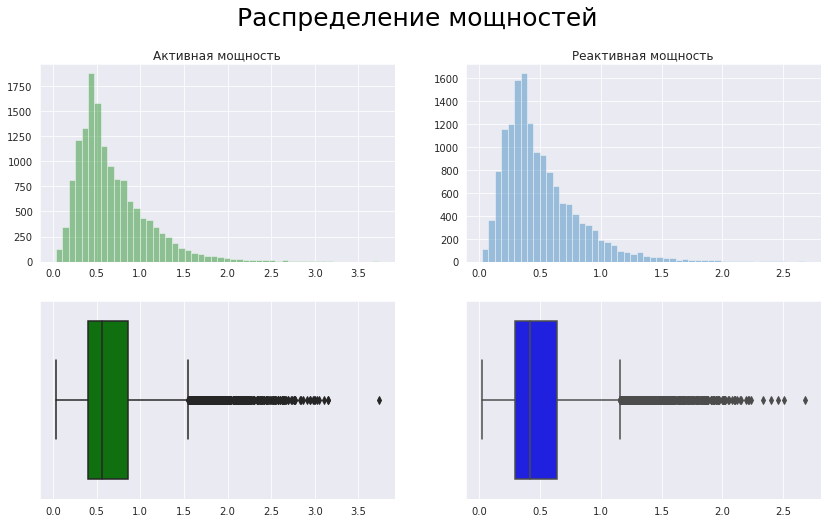

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Распределение мощностей', fontsize=25, color='black')

sns.distplot(data_arc['Активная мощность'], 
             kde=False, color='g', ax=axes[0,0]).set(xlabel=None, title='Активная мощность')
sns.boxplot(data_arc['Активная мощность'], ax=axes[1,0], color='g').set(xlabel=None)

sns.distplot(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'], 
             kde=False, ax=axes[0,1]).set(xlabel=None, title='Реактивная мощность') 
sns.boxplot(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'], ax=axes[1,1], color='b').set(xlabel=None);

Распределения данных активной и реактивной мощностей приближены к нормальным, но заметно смещены влево из-за выбросов. Вероятно, стоит изучить и обработать распределение значений после формирования единой таблицы, так как объем и состав данных может быть изменен. 

<font color='green'>**2. Таблица данных о подаче сыпучих материалов (объем)**</font> <a id='bulk_volume'></a>

In [8]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [9]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Все значения в таблице целочисленные, но в столбцах **bulk 1-15** имеют тип float - необходимо привести их к int. 

В таблице очень много пропусков. Посмотрим, как они распределены и оценим их объем:

In [10]:
bulk_NaN = (data_bulk.isnull().sum().nlargest(15)/data_bulk.shape[0]*100).round(2)
pd.concat([bulk_NaN], axis=1, keys=['Пропуски, %']).style.background_gradient(cmap='Blues')

,"Пропуски, %"
Bulk 8,99.97
Bulk 13,99.42
Bulk 9,99.39
Bulk 2,99.3
Bulk 7,99.2
Bulk 5,97.54
Bulk 10,94.38
Bulk 11,94.34
Bulk 1,91.95
Bulk 6,81.59


In [11]:
(data_bulk.isnull().sum().sum()/data_bulk.size*100).round(2)

71.46

Пропуски есть во всех столбцах - их общая доля от выборки составляет 72%. Пропуски стоит заполнить нулевым значением и работь с тем, что получим.

<font color='green'>**3. Таблица данных о подаче сыпучих материалов (время)**</font> <a id='bulk_time'></a>

In [12]:
data_bulk_time.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40


In [13]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


В этой таблице содержится информация о номере партии и времени совершения процесса, но отсутствует какая-либо информация о замере температуры. Данную таблицу можно исключить из исследования, как нерелевантную. 

<font color='green'>**4. Таблица данных о продувке сплава газом**</font> <a id='gas'></a>

In [14]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [15]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [16]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Пропусков нет. Отметим только один момент - название столбца на русском *Газ 1* - переведем на английский. 

Посмотрим на распределение:

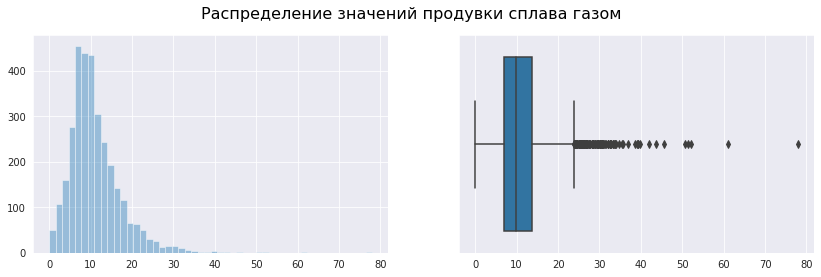

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Распределение значений продувки сплава газом', fontsize=16, color='black')

sns.distplot(data_gas['Газ 1'], kde=False, ax=axes[0]).set(xlabel=None)
sns.boxplot(data_gas['Газ 1']).set(xlabel=None);

Данные смещены влево и есть выбросы. Как и в случае с распределением значений мощностей, стоит изучить выборку после формирования единой таблицы и принять решения насчет обработки.

<font color='green'>**5. Таблица данных о проволочных материалах (объем)**</font> <a id='wire_volume'></a>

In [18]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Ситуация схожа с data_bulk: пропуски присутствуют в данных о замерах, а номера партии в порядке - без NaN. 

Посмотрим на соотношение NaN и их объем:

In [20]:
wire_NaN = (data_wire.isnull().sum().nlargest(9)/data_wire.shape[0]*100).round(2)
pd.concat([wire_NaN], axis=1, keys=['Пропуски, %']).style.background_gradient(cmap='Blues')

,"Пропуски, %"
Wire 5,99.97
Wire 7,99.64
Wire 4,99.55
Wire 8,99.38
Wire 9,99.06
Wire 3,97.96
Wire 6,97.63
Wire 2,64.98
Wire 1,0.84


In [21]:
(data_wire.isnull().sum().sum()/data_wire.size*100).round(2)

75.9

В таблице отсутствует 76% данных. Пропуски практически во всех колонках. Тем не менее, имеющиеся значения важны, а пропуски заполним нулями.

<font color='green'>**6. Таблица данных о проволочных материалах (время)**</font> <a id='wire_time'></a>

In [22]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [23]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Как и в случае с *data_bulk*, данная таблица не содержит сведений, которые были бы полезны в исследовании. Исключим таблицу из работы.

<font color='green'>**7. Таблица данных о результатах измерения температуры**</font> <a id='temp'></a>

In [24]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [25]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [26]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

В датасете несколько названий колонок на русском языке - изменим на английский для удобства. В столбце о замерах температуры есть пропуски. Данные без показателя температуры бесполезны. Поэтому такие строки логично удалить.

Посмотрим на распределение температур:

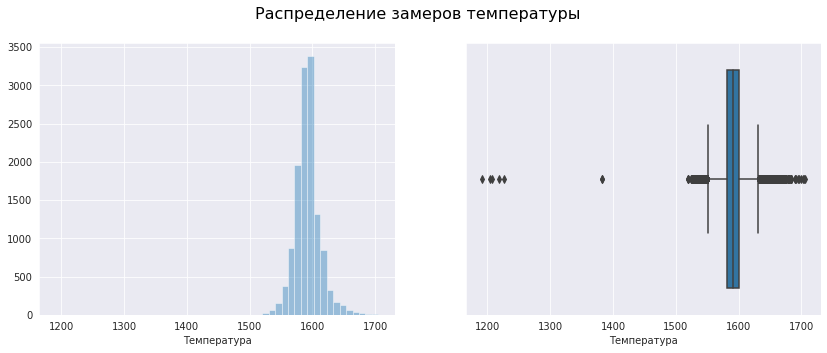

In [27]:
fig, axes = plt.subplots(1,2, figsize=(14, 5))
fig.suptitle('Распределение замеров температуры', fontsize=16, color='black')

sns.distplot(data_temp['Температура'].dropna(), kde=False, ax=axes[0]).set(xlabel='Температура')
sns.boxplot(data_temp['Температура'],  ax=axes[1]).set(xlabel='Температура');

Значения температур сильно смещены вправо из-за выбросов. Кроме того, видно, что начальное время замера температуры "11:16:18". К этому моменту уже было произведено несколько итераций по нагреву сплава электродами. То есть, в **data_arc** и **data_temp** фиксации времени того или иного процесса различны. Поэтому необходимо использовать только те номера партий, которые имеют соотносимые данные о замере температуры.

Поэтому при подготовке данных необходимо учесть такие несостыковки и выделить только корректные номера партий.

# Вывод <a id='summary_1'></a>

|№| Проблема |Решение |
|:------------- |:------------------|:---------------|
|1|Наличие пропусков в *data_bulk*, *data_wire*|Заполним нулями|
|2|Наличие NaN в *data_temp*|Удалим строки с пропусками |
|3|Нерелевантные датасеты *bulk_time*, *wire_time*|Не будем использовать их в исследовании|    
|4|Некорректные типы данных (время в object, ~целые числа в float~)|Приведем данные к нужному типу|
|5|Название столбцов на разных языках |Переведем все на английский|
|6|Аномальное значение в *data_arc['Реактивная мощность']*|Удалим|
|7|Несоответсвие времени замера процессов в партиях|Выбрать партии с подходящим соотношением номера и времени замера|

## Подготовка данных 
<a id='data_preparation'></a>

### Предобработка данных 
<a id='data_preprocessing'></a>

Отредактируем данные, чтобы подготовить их к формированию итоговой таблицы.

Удалим аномальное значение в *data_arc*, чтобы не сбивать вычисления:

In [28]:
data_arc = data_arc.drop(index=[9780]).reset_index(drop=True)

Для всех таблиц, которые будем использовать в дальнейшем, установим *key* в качестве индекса: 

In [29]:
data_arc = data_arc.set_index('key')
data_temp = data_temp.set_index('key')
data_gas = data_gas.set_index('key')
data_bulk = data_bulk.set_index('key')
data_wire = data_wire.set_index('key')

Переименуем столбцы отобраных датасетов:

In [30]:
data_arc.columns = ['start_time','end_time', 'active_power', 'reactive_power']
data_gas.columns = ['gas_1']
data_temp.columns = ['time_starts', 'temp']
data_bulk.columns = [f'bulk_{x}' for x in range(0,15)]
data_wire.columns = [f'wire_{x}' for x in range(0,9)]

В таблицах *data_bulk* и *data_wire* пропуски заполним нулевыми значениями:

In [31]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [32]:
#Удалим пропуски в data_temp, так как именно здесь находится целевой признак, и запонять их было бы некорректно:

#data_temp = data_temp.dropna()

Исследование данных позволило выявить некоторые несостыковки относительно замеров температуры. В некоторых партиях итоговый замер температуры производился до завершения процесса нагрева. Также есть случаи, когда начальный и конечный замеры температуры совпадали. Такие случаи необходимо исключить из данных, так как показатель *температуры* является ключевым в данном проекте.

С помощью цикла составим список *некорректных данных*:

In [33]:
incorrect_indexes = []
for i in list(data_temp.index.unique()):
    try:
        if ((data_arc[data_arc.index == i]['end_time'].max() > 
        data_temp[data_temp.index == i]['time_starts'].max()) 
        or
        (data_temp[data_temp.index == i]['time_starts'].min() == 
        data_temp[data_temp.index == i]['time_starts'].max())):
            incorrect_indexes.append(i)
    except:
        incorrect_indexes.append(i)
len(incorrect_indexes)

171

Обнаружили 171 случай. Исключим их из *data_temp*:

In [34]:
data_temp = data_temp.query('index not in @incorrect_indexes')
data_temp = data_temp.dropna()

Теперь создидим срез, убрав партии, содержащие только один замер температуры: 

In [35]:
incorrect_indexes_sum = (data_temp.index.value_counts() == 1 ).sum() 
correct_indexes = list(data_temp.index.value_counts().index[:-incorrect_indexes_sum])
data_temp = data_temp.query('index in @correct_indexes')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11680 entries, 1 to 2499
Data columns (total 2 columns):
time_starts    11680 non-null datetime64[ns]
temp           11680 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 273.8 KB


С данными всё в порядке, они подготовлены. 

Приступаем к формированию итогового датасета.

### Формирование единой таблицы 
<a id='final_data'></a>

Для итоговой таблицы  часть данных мы сгруппируем, а с некоторыми произведем расчеты и сделаем новые столбцы. 

Создадим столбец со значениями полной мощности, которую по формуле $S = √(P^2 + Q^2)$:

In [36]:
# вычисление полной мощности
data_arc['total_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5 

In [37]:
# создание столбца с показателем полной мощности по партии

data_arc_powers = data_arc.groupby('key').agg([np.mean])['total_power'] 
data_arc_powers.columns = ['total_power']
data_arc_powers.head()

,total_power
key,
1,1.165279
2,0.912304
3,0.597907
4,0.953741
5,1.008939


Также сделаем колонку со знаяениями коэффициентра мощности:

In [38]:
# расчет коэффициента мощности
data_arc['cos_fi'] = data_arc['active_power']/data_arc['total_power']
data_arc_cos = data_arc.groupby('key').agg([np.mean])['cos_fi']
data_arc_cos.columns = ['cos_fi']
data_arc_cos.head()

,cos_fi
key,
1,0.837756
2,0.840158
3,0.845421
4,0.841682
5,0.828104


Создадим столбец с числом запусков электродов:

In [39]:
data_arc_num = data_arc.groupby('key').agg([np.count_nonzero])['active_power']
data_arc_num.columns = ['launch_num']
data_arc_num.head()

,launch_num
key,
1,5.0
2,4.0
3,5.0
4,4.0
5,4.0


Перейдем к таблице *data_temp*. 

Необходимо оставить только первый и последний замер температуры, исключив промежуточные. Это избавит модель от запоминания в предсказаниях и, как результат, переобучения.  

Сначала сгруппируем данные времени замеров:

In [40]:
data_temp_min_max = data_temp.groupby('key').agg([np.min, np.max])['time_starts']
data_temp_min_max.columns = ['time_first', 'time_last']
data_temp_min_max.head()

,time_first,time_last
key,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39
2,2019-05-03 11:37:27,2019-05-03 11:59:12
3,2019-05-03 12:13:17,2019-05-03 12:34:57
4,2019-05-03 12:52:57,2019-05-03 12:59:25
5,2019-05-03 13:23:19,2019-05-03 13:36:01


Создадим списки первых и последних замеров:

In [41]:
start_time = list(data_temp_min_max['time_first']) #список значений первой колонки data_temp
end_time = list(data_temp_min_max['time_last']) #список значений последней колонки data_temp

На основе полученных данных создадим таблицу с требуемыми замерами температур: 

In [42]:
data_temp_start = data_temp.query('time_starts in @start_time')
data_temp_end = data_temp.query('time_starts in @end_time')

data_temp_final = pd.concat([data_temp_start, data_temp_end], axis=1, sort=False)
data_temp_final.columns = ['time_first', 'temp_start', 'time_last', 'temp_end'] 
data_temp_final = data_temp_final[['temp_start', 'temp_end']]
data_temp_final.head()

,temp_start,temp_end
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [43]:
data_temp_final.tail()

,temp_start,temp_end
key,,
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0
2498,1591.0,1594.0
2499,1569.0,1603.0


Данные собраны - объединим их в итоговую таблицу:

In [44]:
data = pd.DataFrame(data_arc_powers).join([data_arc_cos, data_arc_num, data_gas, data_bulk, data_wire, data_temp_final])
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210 entries, 1 to 2499
Data columns (total 30 columns):
total_power    2210 non-null float64
cos_fi         2210 non-null float64
launch_num     2210 non-null float64
gas_1          2210 non-null float64
bulk_0         2210 non-null float64
bulk_1         2210 non-null float64
bulk_2         2210 non-null float64
bulk_3         2210 non-null float64
bulk_4         2210 non-null float64
bulk_5         2210 non-null float64
bulk_6         2210 non-null float64
bulk_7         2210 non-null float64
bulk_8         2210 non-null float64
bulk_9         2210 non-null float64
bulk_10        2210 non-null float64
bulk_11        2210 non-null float64
bulk_12        2210 non-null float64
bulk_13        2210 non-null float64
bulk_14        2210 non-null float64
wire_0         2210 non-null float64
wire_1         2210 non-null float64
wire_2         2210 non-null float64
wire_3         2210 non-null float64
wire_4         2210 non-null float64
wire_

In [45]:
data.head(3)

,total_power,cos_fi,launch_num,gas_1,bulk_0,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,temp_start,temp_end
key,,,,,,,,,,,,,,,,,,,,,
1,1.165279,0.837756,5.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0
2,0.912304,0.840158,4.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0
3,0.597907,0.845421,5.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0


Проверим данные на корреляцию:

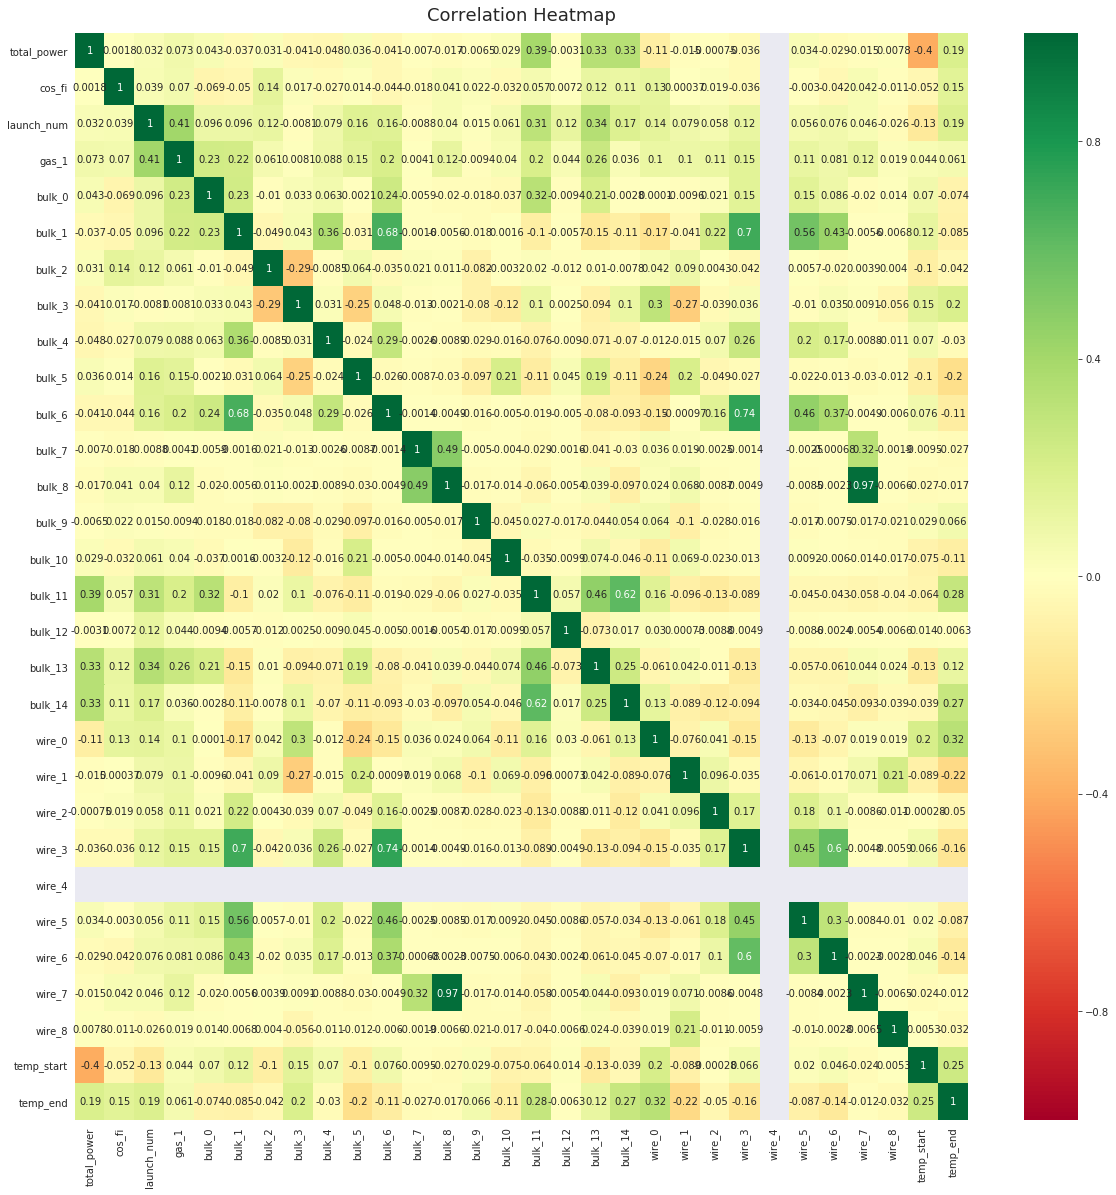

In [46]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12); 

Переменные *bulk_8* и *wire_7* сильно коррелируют друг с другом. Чтобы не ухудшить производительность алгоритмов удалим *wire_7* и еще *wire_4*, как пустой столбец.

In [47]:
del data['wire_4']
del data['wire_7']

В данных наверняка есть выбросы. Посмотрим на распределения начальной и конечной температуры, полной мощности, коэффициента мощности и объема газа с помощью *box plot*:

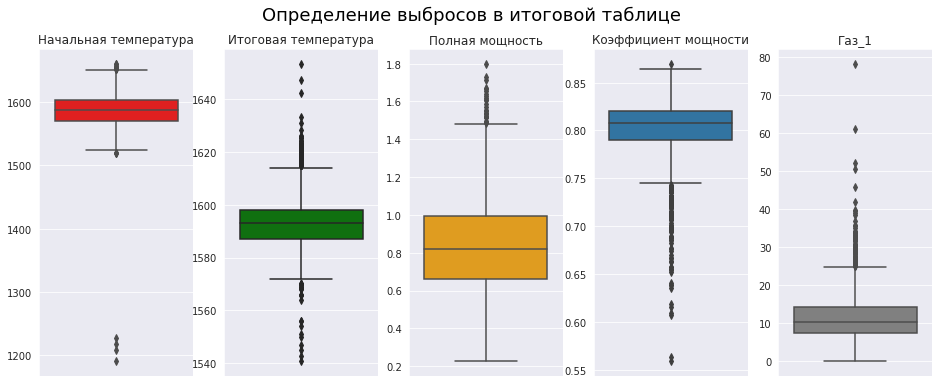

In [48]:
fig, ax = plt.subplots(1, 5, figsize=(16,6))
fig.suptitle('Определение выбросов в итоговой таблице', fontsize = 18, color='black')

sns.boxplot(data['temp_start'], orient='v', color='red', ax=ax[0]).set(ylabel=None, title='Начальная температура')
sns.boxplot(data['temp_end'], orient='v', color='g', ax=ax[1]).set(ylabel=None, title='Итоговая температура')
sns.boxplot(data['total_power'], orient='v', color='orange', ax=ax[2]).set(ylabel=None, title='Полная мощность')
sns.boxplot(data['cos_fi'], orient='v', ax=ax[3]).set(ylabel=None, title='Коэффициент мощности')
sns.boxplot(data['gas_1'], orient='v', color='grey', ax=ax[4]).set(ylabel=None, title='Газ_1');                    

Значительные аномалии наблюдаем в значениях начальной температуры. В других столбцах также довольно много выбросов.

Чтобы не терять слишком много данных, не будем механически "отрезать" выбросы, находящиеся за границами усов.

Вместо этого используем метод ближайших соседей - KNN() .

In [49]:
data_knn = data

model = KNN()
model.fit(data_knn)

data_knn['estimation_knn'] = model.fit_predict(data_knn) == 1
outliers_knn = data_knn['estimation_knn'].sum()
data = data.drop(data_knn[data_knn['estimation_knn']==1].index)
data = data.drop('estimation_knn', axis=1)

print('Количество аномалий (KNN): ', outliers_knn)
print('Размер датасета: ', data.shape)

Количество аномалий (KNN):  221
Размер датасета:  (1989, 28)


Посмотрим, как изменились распределения:

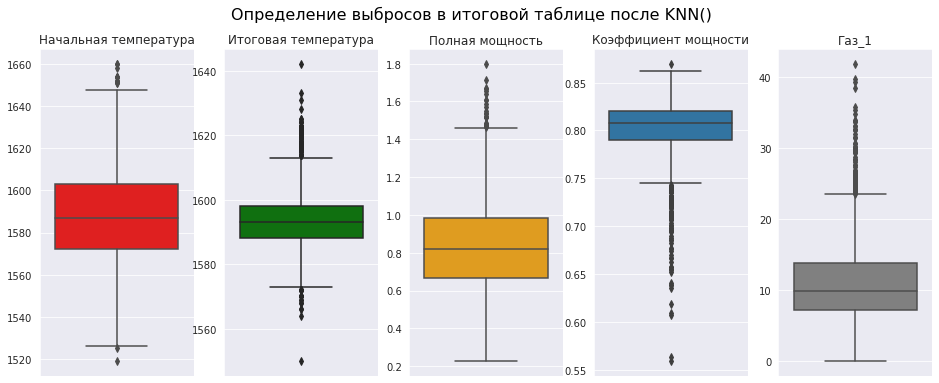

In [50]:
fig, ax = plt.subplots(1, 5, figsize=(16,6))
fig.suptitle('Определение выбросов в итоговой таблице после KNN()', fontsize = 16, color='black')

sns.boxplot(data['temp_start'], orient='v', color='red', ax=ax[0]).set(ylabel=None, title='Начальная температура')
sns.boxplot(data['temp_end'], orient='v', color='g', ax=ax[1]).set(ylabel=None, title='Итоговая температура')
sns.boxplot(data['total_power'], orient='v', color='orange', ax=ax[2]).set(ylabel=None, title='Полная мощность')
sns.boxplot(data['cos_fi'], orient='v', ax=ax[3]).set(ylabel=None, title='Коэффициент мощности')
sns.boxplot(data['gas_1'], orient='v', color='grey', ax=ax[4]).set(ylabel=None, title='Газ_1');  

Начальная температура оказалась почти полностью без выбросов. Их количество заметно сократилось в остальных столбцах, помимо коэффициента мощности, который остался без изменений. используем такие данные для обучения.

# Вывод <a id='summary_2'></a>

Данные были подготовлены для обучения. 

1. Произведена предобработка (удаление аномалий, заполнение/удаление NaN).
2. Сформирована итоговая таблица: 
  * из данных исключены между итоговыми замерами температуры и последним нагревом сплава электродами;
  * созданы новые столбцы со значениями коэффициента мощности и количества производимых нагревов электродами;
  * сделаны срезы данных по температуре - оставлены только значения начальной и итоговой температуры.
3. Произведена проверка на мультиколлинеарность. Несколько столбцов в итоге удалено.
4. Произведен поиск аномалий с помощью метода KNN() - аномалии удалены.

## Обучение моделей 
<a id='models'></a>

Произведем обучение моделей и модель, показавшую лучший результат, протестируем на отдельной выборке.

Для обучения выберем следующие модели:

1. LinearRegression();
2. Ridge();
3. RandomForestRegressor();
4. CatBoostRegressor();
5. LGBMRegressor() 

Подготовим данные к обучению. 

In [51]:
random_state = 12345

X = data.drop('temp_end', axis=1)
y = data['temp_end']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random_state)

print('Размер обучающей выборки: ', X_train.shape)
print('Размер тестовой выборки: ', X_test.shape)

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=random_state)

Размер обучающей выборки:  (1392, 27)
Размер тестовой выборки:  (597, 27)


Обучим модели.

<font color='green'>**1. LinearRegression**</font> <a id='linear'></a>

In [52]:
%%time

lr_model = LinearRegression()
lr_train_mae  = (cross_val_score(lr_model, 
                            X_train, y_train, 
                            cv=cv, 
                            scoring='neg_mean_absolute_error').mean() * -1)
print('lr_MAE =', lr_train_mae, '\n')

lr_MAE = 6.507992190767324 

CPU times: user 1.98 s, sys: 1.42 s, total: 3.39 s
Wall time: 3.37 s


<font color='green'>**2. Ridge**</font> <a id='ridge'></a>

In [53]:
%%time 

r_model = Ridge(random_state=random_state)
r_train_mae = cross_val_score(r_model, 
                              X_train, y_train,
                              cv=cv, 
                              scoring='neg_mean_absolute_error').mean() * -1
print('r_MAE =', r_train_mae, '\n')

r_MAE = 5.9035785770924 

CPU times: user 1.39 s, sys: 1.15 s, total: 2.53 s
Wall time: 2.51 s


<font color='green'>**3. RandomForestRegressor**</font> <a id='rf'></a>

In [54]:
%%time

rf_model = RandomForestRegressor(random_state=random_state) 
rf_train_mae = cross_val_score(rf_model,  
                         X_train, y_train,
                         cv=cv,
                         scoring='neg_mean_absolute_error').mean()* -1
print('rf_MAE =', rf_train_mae, '\n')

rf_MAE = 6.478513155190134 

CPU times: user 4.97 s, sys: 806 µs, total: 4.97 s
Wall time: 5.04 s


<font color='green'>**4. CatBoostRegressor**</font> <a id='cat'></a>

In [55]:
%%time

cat_model = CatBoostRegressor(verbose=False, random_state=random_state)

cat_train_mae = (cross_val_score(cat_model,  
                        X_train, y_train, 
                        cv=cv, 
                        scoring='neg_mean_absolute_error').mean()) * -1
print('cat_MAE =', cat_train_mae, '\n')

cat_MAE = 5.653260484834512 

CPU times: user 11min 34s, sys: 1min 44s, total: 13min 19s
Wall time: 14min 36s


Посмотрим на значимость признаков:

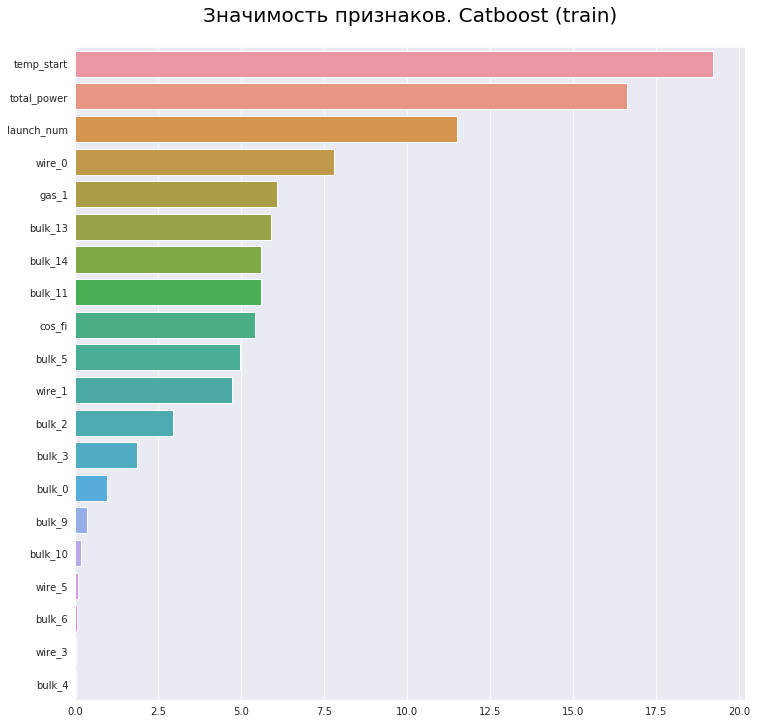

In [56]:
cat_model.fit(X_train, y_train)

cat_feat_imp = pd.Series(cat_model.feature_importances_, index=X_train.columns).nlargest(20)
    
plt.figure(figsize=(12,12))
plt.title('Значимость признаков. Catboost (train)', fontsize=20,  y=1.03, color='black')
sns.barplot(x=cat_feat_imp, y=cat_feat_imp.index)
plt.show()

Для модели Cat-бустинга тройка признаков-лидеров по важности предсказаний - начальная температура, активная мощность и число запусков электродов - логичный выбор. 

Половина же признаков оказалась весьма малозначимой, и это касается ряда столбцов *bulk* и *wire* - вполне объяснимо, так как данные колонки практически полностью заполнены нулевыми значениями.

<font color='green'>**5. LGBMRegressor**</font> <a id='lgb'></a>

In [57]:
%%time

lgb_model = LGBMRegressor(random_state=random_state) 
lgb_train_mae = cross_val_score(lgb_model, 
                           X_train, y_train,
                           cv=cv,
                           scoring='neg_mean_absolute_error').mean()* -1
print('lgb_MAE = ', lgb_train_mae, '\n')

lgb_MAE =  5.883756863416936 

CPU times: user 1min 8s, sys: 0 ns, total: 1min 8s
Wall time: 1min 9s


Выведим на экран диаграмму значимости признаков:

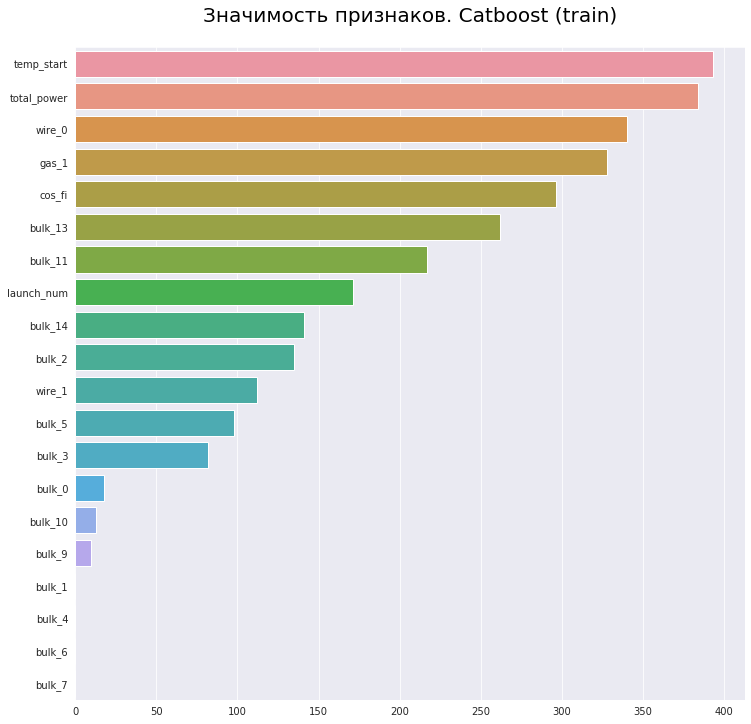

In [58]:
lgb_model.fit(X_train, y_train)

lgb_feat_imp = pd.Series(lgb_model.feature_importances_, index=X_train.columns).nlargest(20)
    
plt.figure(figsize=(12,12))
plt.title('Значимость признаков. Catboost (train)', fontsize=20,  y=1.03, color='black')
sns.barplot(x=lgb_feat_imp, y=lgb_feat_imp.index)
plt.show()

Для модели LGBMRegressor также, как и для CatBoos, начальная температура и активная мощность - ведущие признаки, а бронза досталась колонке *wire_0".

Представим результаты в таблице:

In [59]:
mae_train = pd.DataFrame([lr_train_mae, 
                          r_train_mae, 
                          rf_train_mae, 
                          cat_train_mae, 
                          lgb_train_mae],
                       columns = ['MAE_train'], 
                       index = ['LinearRegressor', 'RidgeRegressor',
                                'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']).sort_values(by='MAE_train')
mae_train

,MAE_train
CatBoostRegressor,5.653260
LGBMRegressor,5.883757
RidgeRegressor,5.903579
RandomForestRegressor,6.478513
LinearRegressor,6.507992


Мы провели обучения разных моделей. По результатам лучшей стала модель CatBoostRegressor.

# Вывод  </font> <a id='summary_3'></a>

Мы построили несколько моделей и обучили их с помощью кросс-валидации. Все модели показали довольно неплохой результат. Но минимальное значение метрики удалось достичь с помощью CatBoostRegressor = 5.65. 

Интересно, что CatBoost в качестве важнейших фичей - начальную температуру, полную мощность и число запусков электродов, а LGBM предпочла признак о проволочных материалах.

Перейдем у тестированию топ-3 моделей.

## Тестирование моделей 
</font> <a id='test'></a>

Проведем проверку моделей на тестовой выборке. Используем Ridge, CatBoost и LGBM, как показавшие наилучшее значение метрики.

**Ridge:**

In [60]:
%%time 

r_test_model = Ridge(random_state=random_state)
r_test_model.fit(X_train, y_train)
r_test_preds = r_test_model.predict(X_test)
r_test_mae = mean_absolute_error(y_test, r_test_preds).mean() 
print('Ridge_test_MAE =', r_test_mae, '\n')

Ridge_test_MAE = 5.871495334378815 

CPU times: user 24.3 ms, sys: 0 ns, total: 24.3 ms
Wall time: 4.89 ms


Построим гистограмму распределения предскзаний и истинных значений на данной модели:

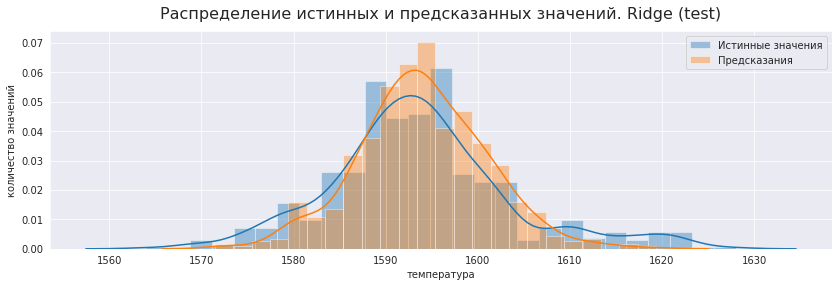

In [61]:
def true_preds_plot(prediction, name):
    plt.figure(figsize=(14, 4))
    plt.title(name, y=1.03, fontsize=16)

    sns.distplot(y_test, label='Истинные значения').set(xlabel='температура', ylabel='количество значений')
    sns.distplot(prediction, label='Предсказания')
    plt.legend();

true_preds_plot(r_test_preds, 'Распределение истинных и предсказанных значений. Ridge (test)')

Предсказания температур стремится к нормальному распределению. Хорошо видно, что в области температур 1590-1600 градусов возникает дисбаланс с истинными показателями, которые распределены несколько скачкообразно. Вероятно, имея больше данных, предсказания были бы точнее.

**CatBoostRegressor:**

In [62]:
%%time

cat_test_model = CatBoostRegressor(verbose=False, random_state=random_state)
cat_test_model.fit(X_train, y_train)
cat_test_preds = cat_test_model.predict(X_test)
cat_test_mae = mean_absolute_error(y_test, cat_test_preds)
print('Cay_test_MAE =', cat_test_mae)

Cay_test_MAE = 5.632663870659626
CPU times: user 14.8 s, sys: 1.98 s, total: 16.8 s
Wall time: 18.6 s


Посмотрим, какие признаки наибоолее значимы для модели:

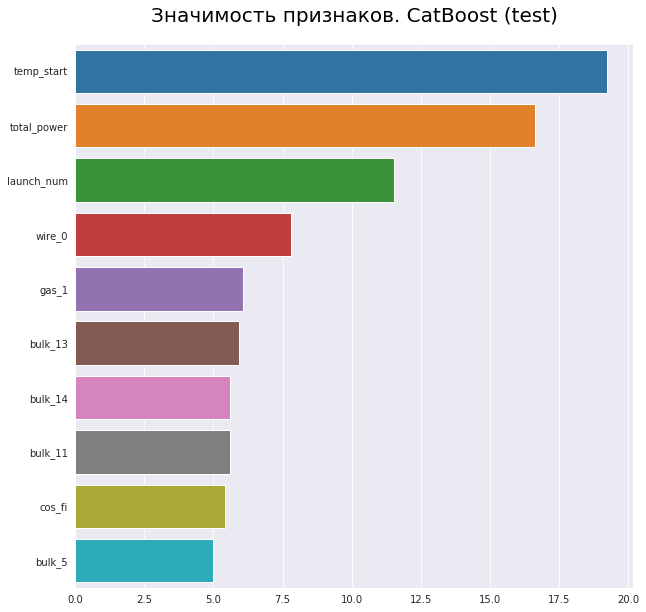

In [63]:
def feat_imp(model, name): 
    data = pd.Series(model.feature_importances_, index=X_test.columns).nlargest(10)
    
    plt.figure(figsize=(10,10))
    plt.title(name, fontsize=20,  y=1.03, color='black')
    sns.barplot(x=data, y=data.index)
    plt.show()

feat_imp(cat_test_model, 'Значимость признаков. CatBoost (test)')

В тройке - начальная температура, полная мощность и число запусков электродами - как и на трейне.

Построим гистограмму распределения предскзаний и истинных значений на данной модели:

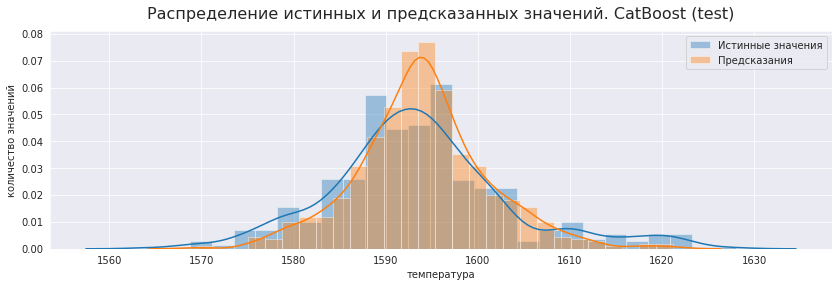

In [64]:
true_preds_plot(cat_test_preds, 'Распределение истинных и предсказанных значений. CatBoost (test)')

Снова модель чаще ошибается в области значений 1590-1600.

**LGBMRegressor**

In [65]:
%%time

lgb_test_model = LGBMRegressor(random_state=random_state) 
lgb_test_model.fit(X_train, y_train)
lgb_test_preds = lgb_test_model.predict(X_test)
lgb_test_mae = mean_absolute_error(y_test, lgb_test_preds)
print('lgb_test_MAE = ', lgb_test_mae, '\n')

lgb_test_MAE =  5.737132706888874 

CPU times: user 3.97 s, sys: 0 ns, total: 3.97 s
Wall time: 4 s


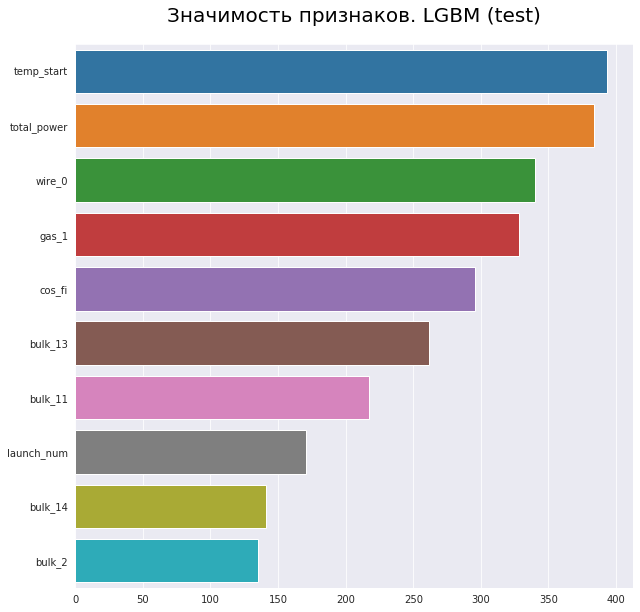

In [66]:
feat_imp(lgb_test_model, 'Значимость признаков. LGBM (test)')

Все модели солидарны в выборе двух наиболее важных фитчей - начальная температура и мощность. Только LGBM ставит температуру на первое место.

Построим гистограмму распределения предскзаний и истинных значений на данной модели:

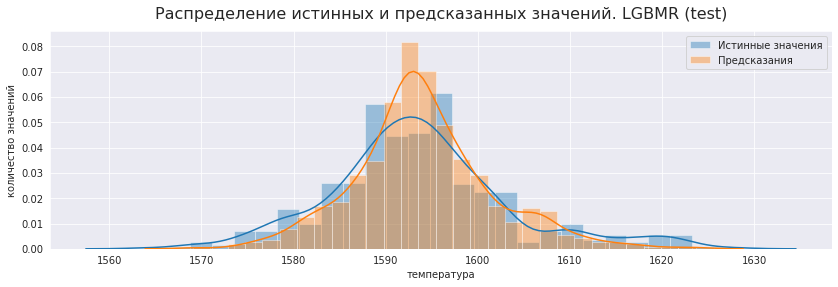

In [67]:
true_preds_plot(lgb_test_preds, 'Распределение истинных и предсказанных значений. LGBMR (test)')

Подведем итог полученных результатов.

Построим таблицу со значениями метрики и выведим результа на экран: 

In [68]:
mae_total = pd.DataFrame([[r_train_mae, r_test_mae], 
                          [cat_train_mae, cat_test_mae], 
                          [lgb_train_mae, lgb_test_mae]],
                       columns = ['MAE_train', 'MAE_test'], 
                       index = ['RidgeRegressor', 'CatBoostRegressor', 
                                'LGBMRegressor']).sort_values(by='MAE_test')
mae_total

,MAE_train,MAE_test
CatBoostRegressor,5.653260,5.632664
LGBMRegressor,5.883757,5.737133
RidgeRegressor,5.903579,5.871495


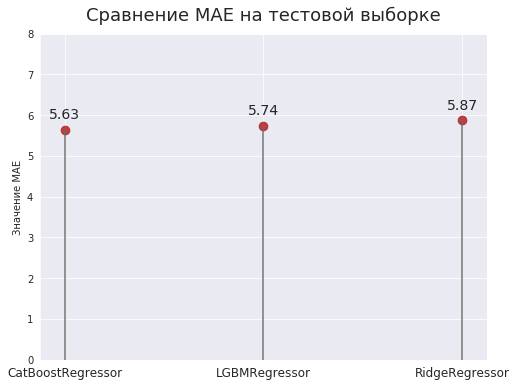

In [69]:
def scatter_mae(data):
    fig, ax = plt.subplots(figsize=(8,6))

    ax.vlines(x=data.index, ymin=0, ymax=data['MAE_test'], color='dimgrey', alpha=0.7, linewidth=2)
    ax.scatter(x=data.index, y=data['MAE_test'], s=75, color='firebrick', alpha=0.85)

    ax.set_title('Сравнение МАЕ на тестовой выборке', size=18, y=(1.02))
    ax.set_ylabel('Значение MAE')
    ax.set_ylim(0,8)
    ax.set_xticks(data.index)
    ax.set_xticklabels(data.index, rotation=0, fontdict={'horizontalalignment': 'center', 'size':12})


    for row in data.itertuples():
        ax.text(row.Index, row.MAE_test+.2, s=round(row.MAE_test, 2), 
           horizontalalignment= 'center', verticalalignment='bottom', fontsize=14);
scatter_mae(mae_total)

Видим, что и на тестовой выборке Cat-бустинг делает предсказания несколько точнее других моделей. Кроме того, разница MAE на трейне и тесте практически отсутсвует. Модель хорошо обучилась. В итоге, модель предсказывает итоговую температуру плавления стали с точностью до ±5.6 градусов.

# Вывод 
<a id='summary_4'></a>

Данные были подготовлены для обучения. Построены несколько моделей. Лучший результат показала модель CatBoostRegressor, давшая на тестовой выборке MAE=5.6.

Кроме того, мы выяснили, что:

1. Для бустинговых моделей оптимальными значимыми признаками стали показатели начальной температуры и полной мощности. 

2. Все модели допустили большее число ошибок в области температур 1590-1600 градусов. 

# Общий вывод 
<a id='conclusion'></a>

**Подведем итог**.

Задача проекта - построить модель, которая предскажeт температуру стали, что в итоге позволит оптимизировать производственные расходы и уменьшить потребление электроэнергии на этапе обработки стали. 

Целью обучения моделей было достижение MAE <= 6.8. 

Для этого:

1. Мы изучили информацию о процессе обработки стали. Сведения содержались в семи датасетах. Данные были исследованы и выявлены проблемы, требующие предобработки (пропуски, аномалии, некорректное соотношение переменных разных датасетов и пр.)

2. В результате данные были обработаны и по итогу мы сформировали новую таблицу с необходимыми срезами, дополнив ее столбцами с новыми расчетами (коэффициент мощности, количество замеров электродами); 

2. Провели исследование моделей на обучающей выборке с помощью различных алгоритмов (LinearRegression, Ridge, RandomForestRegressor, CatBoostRegressor, LGBMRegressor). В итоге лучшей оказалась модель градиентного бустинга CatBoost.

3. Применили итоговую модель к тестовой выборке и получили результат MAE = 5.6. Такие параметры, как начальная температура и активная мощность, стали наиболее важными признаками для модели. 

</font> <a id='report'></a>
# ОТЧЕТ

**Финальный проект - Промышленность**

Металлургический комбинат ООО "Так закаляем сталь" стремился оптимизировать производственные расходы, уменьшив потребление электроэнергии на этапе обработки стали. 

Нашей задачей было построить модель, предсказывающую температуру стали. Критерий оценки - *mae* не более 8.7, в идеале - менее 6.

Заказчик предоставил следующие данные:

- об электродах;
- о подаче сыпучих материалов (объем/время);
- данные о продувке сплава газом;
- результаты измерения температуры;
- данные о проволочных материалах (объём/время).

# 1. Пункты плана

Проект был структурирован, действия выполнялись по намеченому плану. В табличном виде опишем суть шагов и их результат: 

|<font color='blue'>№</font>|<font color='blue'>ЗАПЛАНИРОВАНО</font>|<font color='blue'>РЕАЛИЗОВАНО</font>|<font color='blue'>КОММЕНТАРИИ</font>|
|:-:|:-------------|:------------------|:--------|
|1|Загрузка и изучение данных|✔ всё по плану|*no comment* 😎|
|2|Предобработка данных: обработка NaN/аномалий; изменение типов данных/названий столбцов; назначение key индексом датасетов|✔ всё по плану; **но!** подготовка данных в *data_temp* изначально была неполной; после ревью всё было исправлено|Благодаря замечаниям код-ревьюера из *data_temp* были удалены партии, не имеющие итогового замера температуры (т.е. таргета)|
|3|Формирование единой таблицы: идей было много; помимо выбора и объединения имеющихся данных, была цель создать новые признаки на основе расчетов имеющихся данных|всё иначе: длительность замеров и сумма активной/реактивной мощностей, как признаки, не использовались; новыми признаками стали *полная мощность* и *коэффициент мощности*|итоговое значение *MAE* было основополагающими в подготовке признаков; временные данные коррелировали с другими признаками и были исключены; в качестве "новых" признаков добавлены полная мощность и коэффициент мощности|
|4|Подготовка данных к обучению|✔ всё по плану|*no comment* 😎|
|5|Обучение моделей LinearRegression, RandomForest, XGBoost, CatBoost, LightGBM |Добавлен Ridge, исключен XGBoost|Выбор *Ridge*  обоснован способностью модели к работе с признаками, склонными к корреляции и, как результат, дальнейшей демонстрации неустойчивости оценок;  модель XGBoost не применялась, так как современных CatBoost & LightGBM было более, чем достаточно|


После исследования данных стало ясно, что не все предоставленные данные имеет смысл использовать в работе. Поэтому таблицы *bulk_time* и *wire_time* были исключены.

# 2. Ключевые шаги в решении задачи

Подготовка данных к моделированию стала одной из основных пунктов проекта. Помимо простых действий (заполнение/удаление пропусков, изменение типов данных), нужно было грамотно выделить и подготовить целевой признак, проводя сравнения замеров температур с данными других датасетов. Корректная подготовка партий в датасете *data_temp* стала одним из ключевых моментов в достижении оптимального значения *mae*. 

Другим важным и непростым шагом стала работа с подготовкой признаков к обучению моделей. Выбор признаков напрямую зависел от результатов *mae*. Стремились не только достигнуть более точных предсказаний, но и добиться стабильности результатов. Модель должна была оптимально обучиться - без пере-🤓 и недо-🥳. 

В итоге финальная таблица, *data*, сформировалась следующим образом:

|<font color='green'>№</font>|<font color='green'>СТОЛБЕЦ</font>|<font color='green'>ДАННЫЕ</font>|<font color='green'>ИСТОЧНИК</font>|
|:-:|:-------------|:------------------|:--------|
|1|***total_power***|Полная мощность|расчет полной мощности по формуле 𝑆=√(𝑃2+𝑄2), где *P*-реактивная мощность, *Q* - активная|
|2|***temp_start***| Начальная температура|исходные данные|
|3|***cos_fi***|Коэффициент мощности|расчет коэффициента путем деления активной мощности на полную|
|4|***launch_num***| Количество запусков нагрева сплава электродами|расчет среднего числа запусков на партию|
|5|***gas_1***| Объем газа|исходные данные|
|6|***bulk_***| Подача сыпучих материалов (объем)|исходные данные|
|7|***wire_***| Проволочные материалы (объем)| исходные данные|
|-|***temp_end*** (целевой признак)| Конечная температура|исходные данные|

Далее:

* Была проведена проверка на мультиколлинеарность. В целом, только два столбца, *bulk_8* и *wire_7*, оказались сильно взаимосвязаны - коэффициент Пирсона составил 0.97. Чтобы не ухудшить производительность алгоритмов, *wire_7* ~пришлось покинуть команду~ быд удален. 

* Все столбцы были проверены на наличие аномалий с помощью метода KNN(). Обнаруженные выбросы удалены из данных. Почему именно KNN()? - во время работы с данными сложилось впечатление, что *ручное* удаление выбросов с помощью лимитирования значений по границам усов или немного выходя за них - слишком топорно и плохо сказывается на метрике. *Не все аномалии такие уж аномальные* 😊.

# Итоговый результат

Для анализа было выбрано пять моделей (LinearRegression, Ridge, RandomForestRegressor, CatBoostRegressor). 

Данные были разделены на обучающую и тестовую выборки. Модели обучались на трейне с применением кросс-валидации. Параметры не подбирались - использовались дефолтные (подбор параметров незначительно влиял на метрику).

По результатам обучения лучшей стала модель CatBoost, показавшая результат *mae* < 6. Худший результат был у Случайного леса и Линейной регрессии. 

Для тестирования обученной модели были выбраны три лучшие: *Ridge - CatBoost - LGBM*.

Результаты оценки следующие:

In [70]:
# Значение метрик MAE на трейне и тесте:
mae_total

,MAE_train,MAE_test
CatBoostRegressor,5.653260,5.632664
LGBMRegressor,5.883757,5.737133
RidgeRegressor,5.903579,5.871495


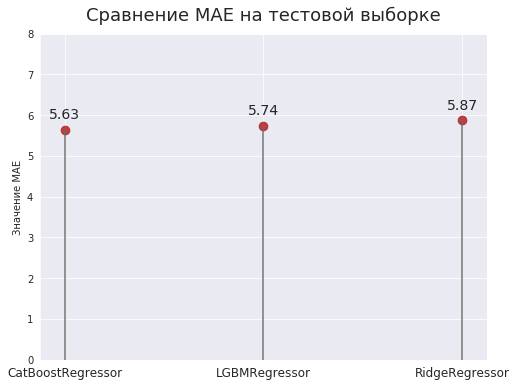

In [71]:
# Значение метрик MAE на тесте:
scatter_mae(mae_total)

Видно, что значения близки, но лучшей оказалась модель CatBoostRegressor, допускающая ошибку в предсказании итоговой температуры в среднем не более ±5.6 градуса. 

Если сравнить истинные значения и предсказания cat-бустингом, то видно, что модель чаще ошибалась в диапазоне температур 1590-1600 градусов.

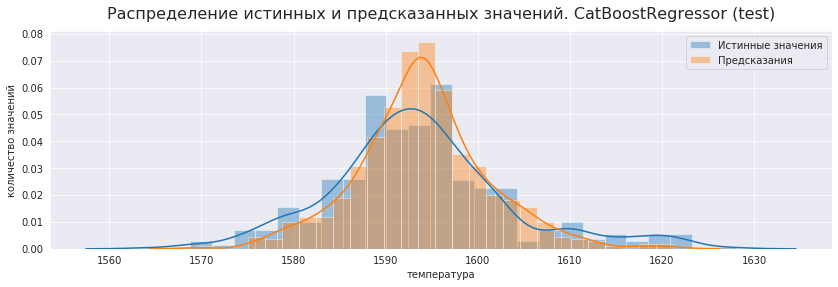

In [72]:
true_preds_plot(cat_test_preds, 'Распределение истинных и предсказанных значений. CatBoostRegressor (test)')

Что касается значимости признаков, то для CatBoost наибольшее значение в предсказании итоговой температуры имели:

1. начальная температура, 
2. полная мощность,
3. количество запусков нагрева электродами. 

Примерно половина признаков оказалась малозначительной. Однако, удаление этих признаков ухудшало прогнозы.

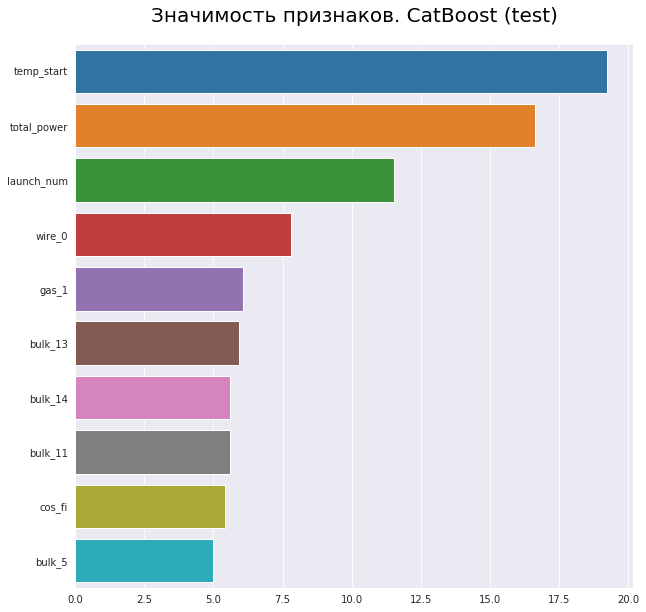

In [73]:
feat_imp(cat_test_model, 'Значимость признаков. CatBoost (test)')

# Итог:  
# *`mae`*  = 5.63  
# `модель` CatBoostRegressor()